# Assignment 7: Semantic Segmentation
Heute werden wir einfache Netzwerkarchitekturen für "Semantic Segmentation" testen. Ziel ist es dieses Paper in den Grundzügen zu implementieren: https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf. Bitte lesen!

## Daten

Es gibt einige gute Datensätze, die ihr (bei gegebener Hardware) herunterladen und benutzen könnt. Für diejenigen, die auf CPUs rechnen gilt immer der Tip: Bilder downsamplen!

Sucht Euch einen Satensatz aus: 

KITTI: http://www.cvlibs.net/download.php?file=data_semantics.zip (~300 MB, 200 Bilder)

DUS: http://www.6d-vision.com/scene-labeling (~3 GB, 500 Bilder)

MIT. http://sceneparsing.csail.mit.edu/ (~1 GB, links siehe auf Seite)

## Exc. 7.1 Fully convolutional network, no downsampling
Implementiere die in der Vorlesung besprochene Netzwerkarchitektur von aufeinanderfolgenden CONV-Schichten (stride=1, mit zero-padding), um eine Ausgabeschicht zu bekommen, die die Eingabegröße aufweist. Tip: die letzte CONV-Schicht sollte eine Tiefe haben, die zur Zahl der Klassen korrespondiert. Benutze den L2-Loss zum Labelbild (Achtung: ihr müsst dafür entweder das Labelbild oder den Ausgabetensor umformulieren).

Trainiere das Netzwerk auf den von Dir gewählten Datensatz und zeige den Verlauf des Losses, und einige zufällig gewählte Beispielbilder mit ihren vorhergesagten Segmentierungen an. (**RESULT**)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import itertools
import tensorflow as tf
import sys

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import binarize

from keras.backend.tensorflow_backend import set_session, get_session
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.models import Sequential
from keras.layers import Dense, Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.backend import argmax, cast
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import optimizers

from skimage import color, io, transform

import PIL

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


def loadImageBatch(path, offset, number, targetShape=None):
    imagePaths = []
    for file in os.listdir(path):
        ext = os.path.splitext(file)[1]
        if ext.lower() not in [".jpg", ".jpeg", ".png"]:
            continue
        imagePaths.append(os.path.join(path, file))
    imagePaths.sort()

    if offset >= len(imagePaths):
        return []
    if offset + number > len(imagePaths):
        number = len(imagePaths) - offset

    images = []  # io.imread_collection(imagePaths[offset:offset+number])
    for imgPath in imagePaths[offset:(offset + number)]:
        # print(imgPath)
        images.append(io.imread(imgPath))

    if targetShape != None:
        for i in range(0, len(images)):
            images[i] = rescale(images[i], targetShape)
    return images


def rescale(img, shape):
    img = transform.resize(img, shape)
    return img


def preprocessBatch(images):
    for i in range(0, len(images)):
        images[i] = preprocess(images[i])
    return images


def preprocess(img):    
    height, width, dim = img.shape
    result = np.zeros((height, width, 150), np.float32)
    for y in range(0, height):
        for x in range(0, width):
            dim = 0
            if type(dim) is not int:
                dim = int(img[y, x, 0] * 255)
            else:
                dim = int(img[y,x,0])
            result[y, x, dim] = 1.0
    return result


def preprocess2(img):
    height, width, dim = img.shape
    result = np.zeros((height, width), np.float32)
    
    for y in range(0, height):
        for x in range(0, width):
            R = 0
            G = 0
            if type(dim) is not int:
                R = int(img[y, x, 0] * 255)
                G = int(img[y, x, 1] * 255)
            else:
                R = int(img[y,x,0])
                G = int(img[y,x,1])
                
            result[y,x] =  int((R)/10)*256+(G)
    return result





def convert2rgb(prediction):
    height, width, depth = prediction.shape
    res = np.zeros((height, width))
    for x in range(0, width):
        for y in range(0, height):
            dimension = np.argmax(prediction[y, x, :])
            if type(dimension) is not int:
                dimension = int(dimension * 255)
            res[y,x] = dimension
    return res

# x, y, 150

In [21]:
# Beispiel für den KITTI-Datensatz. Ich habe die 200 training samples in 180 train- und 20 testbilder
# geteilt (macht 180 samples inkl. labels)
# um uns das Leben leichter zu machen, Bilder heruntersamplen

img_size = (60, 80)

train_image_path = os.path.join("semantic_segmentation_2", "images", "training", "training")
train_label_path = os.path.join("semantic_segmentation_2", "annotations", "training", "training")

# test
# batch_test = loadImageBatch(train_image_path, 300, 10, img_size)
# plt.figure(0, figsize=(19,10))
# plt.imshow(batch_test[0])
# plt.show()


In [3]:
input_shape = (img_size[0], img_size[1], 3)
print(input_shape)
lr = 0.0005
d = 10

model = Sequential()
model.add(Conv2D(d, (3, 3), activation="relu", padding="same", input_shape=input_shape))
model.add(Conv2D(d, (3, 3), activation="relu", padding="same"))
model.add(Dropout(0.1))
model.add(Conv2D(d, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(d, (3, 3), activation="relu", padding="same"))
model.add(Dropout(0.1))
model.add(Conv2D(d, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(d, (3, 3), activation="relu", padding="same"))
model.add(Dropout(0.1))
model.add(Conv2D(d, (3, 3), activation="relu", padding="same"))
model.add(Dropout(0.1))
model.add(Conv2D(150, (3, 3), activation="relu", padding="same"))

model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=lr),
              metrics=['accuracy'])

model.summary()

(60, 80, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 80, 10)        280       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 80, 10)        910       
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 10)        910       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 80, 10)        910       
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 80, 10)        910      

In [22]:
def gen(train_image_path, train_label_path, img_size):
    offset = 0
    
    #train_imgs = []
    #labels = []
    
    while True:
        #for i in range(0,32):
        train_batch = loadImageBatch(train_image_path, offset, 1, img_size)
        label_batch = preprocessBatch(loadImageBatch(train_label_path, offset, 1, img_size))
        offset += 1
        if (len(train_batch) == 0):
            raise StopIteration
        
        train_batch = np.array(train_batch)
        label_batch = np.array(label_batch)
        
        if len(train_batch.shape) != 4:
            print("Detected wrong shape!")
            continue
            
        #train_imgs.append(train_batch)
        #labels.append(label_batch)
        
        yield(np.array(train_batch), np.array(label_batch))


train2_generator = gen(train_image_path, train_label_path, img_size)
abc = train2_generator.__next__()
# about 20.210 images


In [61]:
a = model.fit_generator(train2_generator, steps_per_epoch = 50, epochs = 10)

Epoch 1/10
50/50 [==============================] - 15s 298ms/step - loss: 0.0037 - acc: 0.7751
Epoch 2/10
50/50 [==============================] - 15s 301ms/step - loss: 6.7712e-04 - acc: 1.0000
Epoch 3/10
50/50 [==============================] - 15s 301ms/step - loss: 2.9758e-04 - acc: 1.0000
Epoch 4/10
50/50 [==============================] - 15s 294ms/step - loss: 1.5862e-04 - acc: 1.0000
Epoch 5/10
50/50 [==============================] - 14s 283ms/step - loss: 1.2125e-04 - acc: 1.0000
Epoch 6/10
50/50 [==============================] - 15s 298ms/step - loss: 9.6002e-05 - acc: 1.0000
Epoch 7/10
50/50 [==============================] - 15s 304ms/step - loss: 8.3858e-05 - acc: 1.0000
Epoch 8/10
50/50 [==============================] - 15s 301ms/step - loss: 7.2415e-05 - acc: 1.0000
Epoch 9/10
50/50 [==============================] - 15s 306ms/step - loss: 6.5380e-05 - acc: 1.0000
Epoch 10/10
50/50 [==============================] - 15s 298ms/step - loss: 5.9281e-05 - acc: 1.0000


In [23]:
# print(a.history["loss"]) 
# print(a.history["acc"]) 

In [24]:
#model.save('models/ss-cg-21-02.h5')
#model.save_weights('models/ss-cg-weights-21-02.h5')
#model.load_weights('models/ss-cg-weights-56.h5')

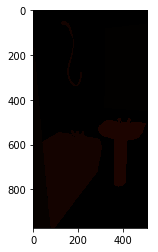

In [36]:
test_image_path = os.path.join("semantic_segmentation_2", "images", "validation", "validation")
test_label_path = os.path.join("semantic_segmentation_2", "annotations", "validation", "validation")


label = io.imread("D:/Users/H3ADLESS/Workspace/PycharmProjects/cv2018/semantic_segmentation_2/annotations/training/training/ADE_train_00000006.png")
plt.imshow(label)


test_generator = gen(test_image_path, test_label_path, img_size)


516.0


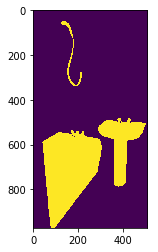

In [37]:
l2 = convert2rgb(preprocess(label))
plt.imshow(l2)
# 76,2
l2 = preprocess2(label)
m = np.amax(l2)
print(m)
l2 = l2 / m
l2.astype(np.int8)
plt.imshow(l2)


(1, 60, 80, 3)
(1, 60, 80, 150)


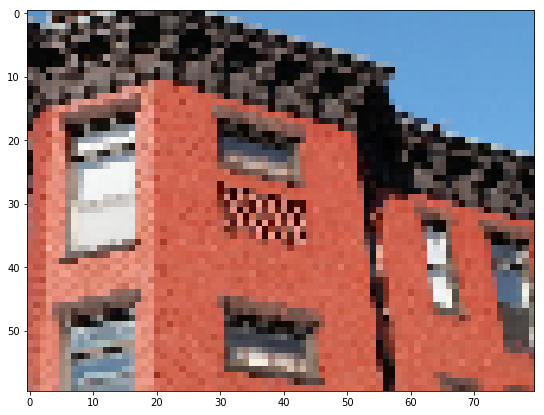

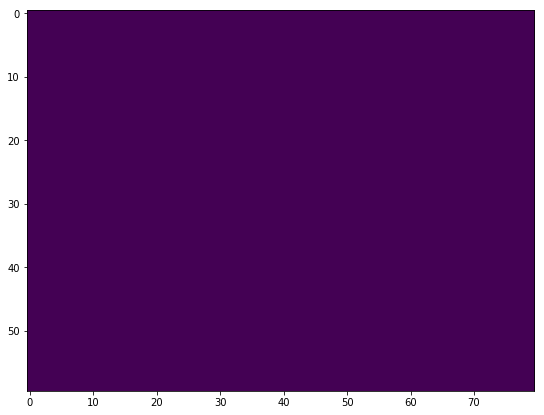

In [72]:
# print(testImg.next()[0].shape)
# image = testImg.next()[0,:,:,:]

img, label = test_generator.__next__()



print(img.shape)
print(label.shape)

# print(img[0])

plt.figure(0, figsize=(20,7))
plt.imshow(img[0])
plt.show()

plt.figure(1, figsize=(20,7))
plt.imshow(convert2rgb(label[0]))
plt.show()

# print(label[0])





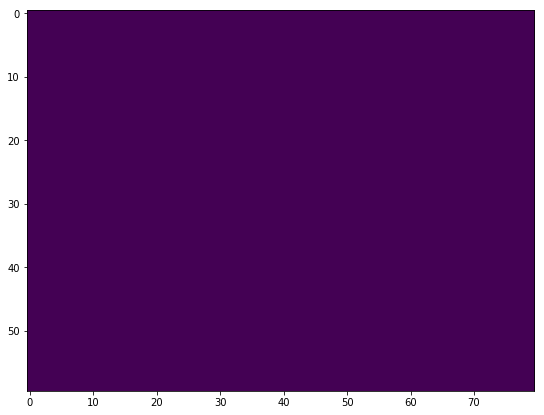

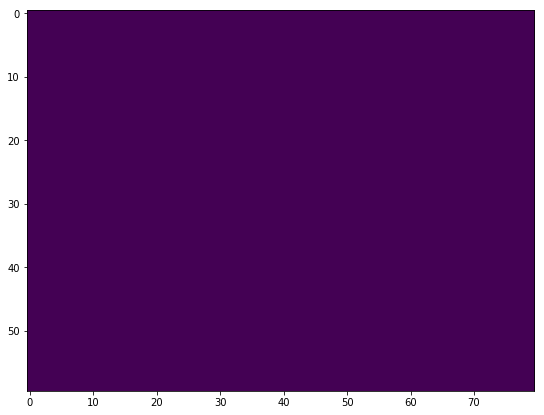

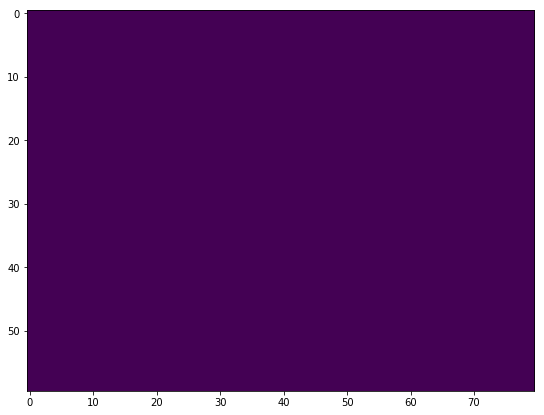

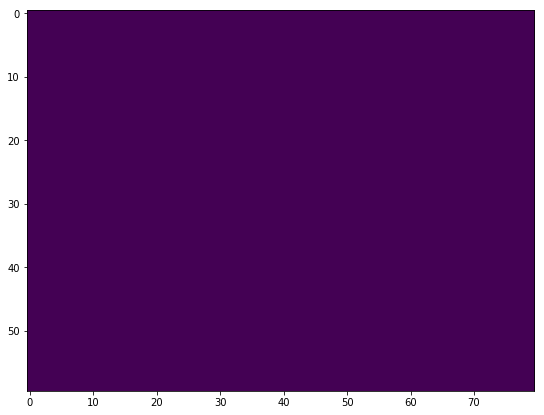

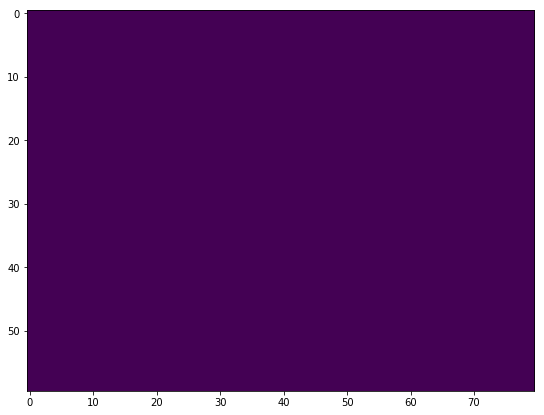

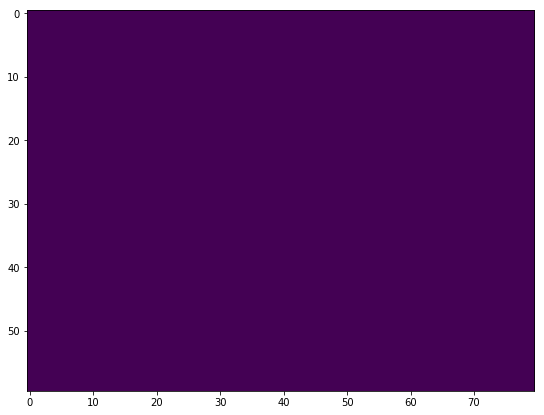

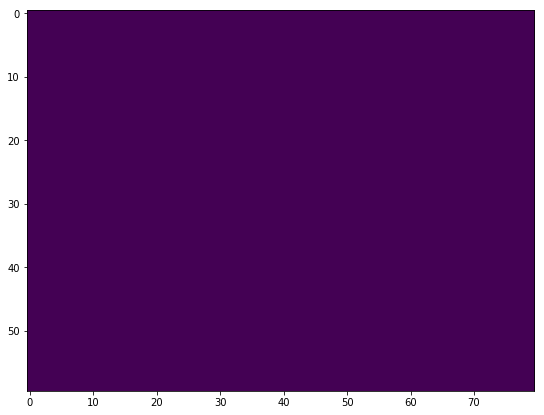

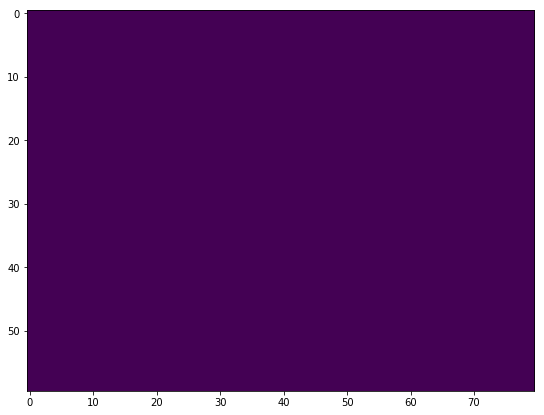

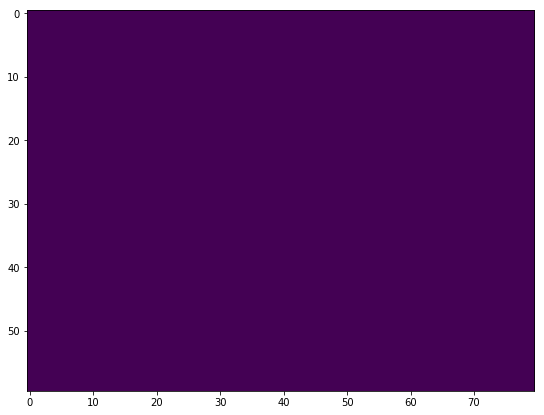

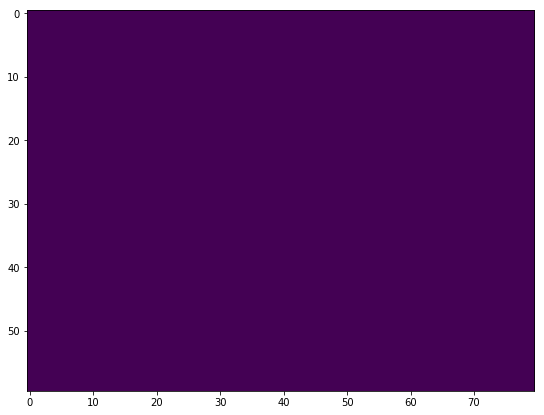

In [74]:
for i in range(0,10):
    img, label = test_generator.__next__()
    prediction = model.predict(img)
    grayscale = convert2rgb(prediction[0,:,:,:])
    plt.figure(i, figsize=(20,7))
    plt.imshow(grayscale)
    
plt.show()



# Exc. 7.2 FCN mit Bottleneck

Implementiere jetzt die Variante mit schrittweisem Down- und Upsampling, wie in der Vorlesung besprochen. Nutze dafür ein bestehendes Netzwerk (z.B. VGG16, https://keras.io/applications/#vgg16), entferne die FC-Schichten am Ende, und füge dann die Upsampling-Schichten hinzu. Wie in der vorigen Vorlesung zu Transfer Learning beschrieben, kannst Du jetzt nur den zweiten Teil trainieren und die Gewichte des ersten Teils "einfrieren".

Stelle wie oben den Verlauf des Losses dar und wähle einige Beispielbilder aus dem Testset und zeige sie mit ihrer vorhergesagten Segmentierung an. (**BONUS**)

In [14]:
vgg16_model = VGG16(weights='imagenet')
vgg16_model.summary()

custom_model = Sequential()
for layer in vgg16_model.layers:
    custom_layer = layer
    custom_layer.trainable = False
    custom_model.add(custom_layer)
    
custom_model.layers.pop()
custom_model.layers.pop()
custom_model.layers.pop()
custom_model.layers.pop()
custom_model.layers.pop()

custom_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
# 
# # add a fully connected layer with 3 outputs, each for one category
custom_model.add(Conv2DTranspose(512, 1))
# custom_model.add(UpSampling2D(size=(2, 2), data_format=None, input))
# custom_model.add(Dense(3, activation="softmax"))
# #custom_model.add(Conv2D(150, (3,3), activation="softmax", padding="same"))  #, (3, 3), activation="relu", padding="same")
custom_model.summary()

ValueError: Input 0 is incompatible with layer conv2d_transpose_5: expected ndim=4, found ndim=2